In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
from copy import deepcopy
from lib_neurips import error, create_K, sinkhorn_em_algorithm_single, em_algorithm_single
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs

import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [2]:
theta = 1
ndata = 1000

In [3]:
Niter = 300
gamma = 0.05
props = np.linspace(0.5,1,51)

#number of repetitions in experiment
nrep = 1
mu_final_em = np.zeros((len(props), nrep, Niter))
mu_final_em_theta = np.zeros((len(props), nrep, Niter))
theta_em = np.zeros((len(props),nrep,Niter,2))
mu_md = np.zeros((len(props),nrep,Niter))
times_em = np.zeros((len(props), nrep))
times_md = np.zeros((len(props), nrep))

In [4]:
for r in range(nrep):
    X0 = np.random.randn(ndata, 1).astype('float32')
    for p0 in range(len(props)): 
        prop = props[p0]
        X = deepcopy(X0)
        X[:int(ndata*prop), 0] += theta
        X[int(ndata*prop):ndata, 0] += -theta
        
        theta0 = np.reshape(np.array([prop, 1-prop]), [2,1])

        log_theta = np.zeros((2,1))
        log_theta[0] = np.log(prop)
        log_theta[1] = np.log(1-prop)
            
        mu00  = np.reshape(np.array([-2, 2]), [2,1]).astype('float32')
        
        start = time.time()
        a,b,seq = em_algorithm_single(X, mu00, 1, log_theta, n_iter=Niter, update_theta=False)
        end = time.time()
        times_em[p0,r] = end-start
        for n in range(Niter):
            mu_final_em[p0,r,n] = seq[n][0,0]


        a,b,seq = em_algorithm_single(X, mu00, 1, log_theta, n_iter=Niter, update_theta=True)

        for n in range(Niter):
            mu_final_em_theta[p0,r,n] = seq[n][1,0]
            theta_em[p0,r,n,:]=b[n].flatten()
            
        start = time.time()
        mu_md[p0, r, :],_,_ = md_lvm.md_gmm_fast(X.flatten(), gamma, Niter, ndata, -2, 2*np.random.binomial(1, 0.5, ndata)-1, prop)
        end = time.time()
        times_md[p0,r] = end-start

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_87311/4157569554.py:13: RuntimeWarning: divide by zero encountered in log
  log_theta[1] = np.log(1-prop)
/Users/francescacrucinio/Documents/MD_LVM/lib_neurips.py:38: RuntimeWarning: divide by zero encountered in log
  log_theta0 = np.log(theta0)
/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:280: RuntimeWarning: divide by zero encountered in log
  ll = -(y-theta*x)**2/2-0.5*np.log(2*np.pi) +np.log((x==-1)+alpha*x)
/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:296: RuntimeWarning: invalid value encountered in multiply
  log_acceptance = (1-(1-gamma)**n)*(ll_gmm_alpha(theta_current, prop, data, alpha) - ll_gmm_alpha(theta_current, v, data, alpha))


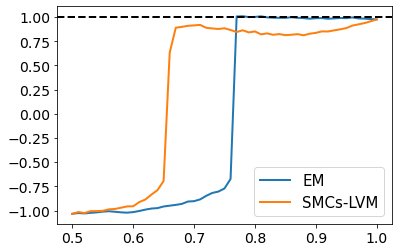

In [8]:
plt.plot(props,mu_final_em[:,0,-1],label='EM', linewidth=2)
plt.axhline(y=theta, c = 'black', linestyle = 'dashed', lw = 2)
plt.plot(props,mu_md[:,0,-1],label='SMCs-LVM', linewidth=2)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('gaussian_mixture.pdf', bbox_inches="tight")

In [6]:
np.mean(times_md)/np.mean(times_em)

1.8708379681484582